In [1]:
import os
from tqdm import tnrange, tqdm_notebook, tqdm
import torch
import torch.nn.functional as F
from torch import nn, autograd, optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms, datasets
from torchvision.utils import save_image, make_grid
from torch.autograd import grad
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tensorboardX import SummaryWriter

In [2]:
# os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [3]:
from matplotlib import rcParams
rcParams['figure.figsize'] = (12, 8)

%matplotlib inline

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
torch.cuda.is_available()

True

In [6]:
device_ids = [0]

In [7]:
BATCH_SIZE = 128
num_epochs = 100

z_dimension = 100
num_feature = 56 * 56

In [8]:
img_transform = transforms.Compose([
    transforms.Resize(64),
    transforms.ToTensor(),
    transforms.Normalize((.5, .5, .5), (.5, .5, .5))
])

dataset = datasets.MNIST('/home/left5/datas/mnist', transform=img_transform) #, download=True)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

In [9]:
def normal_init(m, mean, std):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(mean, std)
        m.bias.data.zero_()

In [10]:
def calc_gradient_penalty(netD, real_data, fake_data):
    alpha = torch.rand(1, 1, 1, 1)
    alpha = alpha.expand_as(real_data)
    alpha = alpha.to(device)
    
    interpolates = alpha * real_data.detach() + ((1 - alpha) * fake_data.detach())

    interpolates = interpolates.to(device)
    interpolates.requires_grad_(True)

    disc_interpolates, _ = netD(interpolates)

    gradients = autograd.grad(outputs=disc_interpolates, inputs=interpolates,
                              grad_outputs=torch.ones(disc_interpolates.size()).to(device),
                              create_graph=True, retain_graph=True, only_inputs=True)[0]

    gradients = gradients.view(gradients.size(0), -1)                              
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * 10
    return gradient_penalty

In [11]:
def gen_noise_label(batch_size):
    label = np.random.randint(0, 10, batch_size)
    #prefix = np.zeros((batch_size, 10))
    #prefix[:, label] = 1
    return label # prefix

In [12]:
def gen_noise(batch_size, label):
    prefix = np.zeros((batch_size, 10))
    prefix[:, label] = 1
    z = np.random.normal(0, 1, (batch_size, z_dimension))
    prefix = prefix / np.linalg.norm(prefix)
    z[:, :10] + prefix
    return torch.from_numpy(z).float().view(-1, 100, 1, 1).to(device)

In [13]:
class Discriminator(nn.Module):
    def __init__(self, d=128):
        super(Discriminator, self).__init__()
        
        self.conv1 = nn.Conv2d(1, d, 4, 2, 1) # d 64 64
        self.conv2 = nn.Conv2d(d, d*2, 4, 2, 1) # d*2 16 16
        self.conv2_bn = nn.BatchNorm2d(d*2)
        self.conv3 = nn.Conv2d(d*2, d*4, 4, 2, 1) # d*4 8 8
        self.conv3_bn = nn.BatchNorm2d(d*4)
        self.conv4 = nn.Conv2d(d*4, d*8, 4, 2, 1) # d*8 4 4
        self.conv4_bn = nn.BatchNorm2d(d*8)
        self.conv5 = nn.Conv2d(d*8, 1, 4, 2, 1) # 1 1 1
        
#         self.conv5 = nn.Sequential(
#             nn.Conv2d(d*8, 1, 4, 1, 0),
#             nn.Sigmoid()
#         ) # b 1 7 7
        
        self.conv6 = nn.Conv2d(d*8, 1, 1) # 1 4 4
        self.fc = nn.Sequential(
            nn.Linear(4*4, 10),
#             nn.LeakyReLU(.2, True),
#             nn.Linear(1024, 10),
            nn.Sigmoid(),
        ) # b 10
        

    
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)
            
    def forward(self, x): # b 1 28 28
        outs = F.leaky_relu(self.conv1(x), 0.2)
        outs = F.leaky_relu(self.conv2_bn(self.conv2(outs)), 0.2)
        outs = F.leaky_relu(self.conv3_bn(self.conv3(outs)), 0.2)
        outs = F.leaky_relu(self.conv4_bn(self.conv4(outs)), 0.2)
        img = torch.sigmoid(self.conv5(outs)) # F.sigmoid
        
#         print(outs.view(x.size(0), -1).shape)
#         outs = F.sigmoid(self.conv5(outs))
#         img = F.sigmoid(outs)
        con = self.conv6(outs) # view(x.size(0), -1)
        con = self.fc(con.view(x.size(0), -1))
        
        return img, con

In [14]:
class Generator(nn.Module):
    def __init__(self, d=128):
        super(Generator, self).__init__()
        
        self.deconv1 = nn.ConvTranspose2d(z_dimension, d*8, 4, 1, 0) # b d*8 4 4
        self.deconv1_bn = nn.BatchNorm2d(d*8)
        self.deconv2 = nn.ConvTranspose2d(d*8, d*4, 4, 2, 1) # b d*4 8 8
        self.deconv2_bn = nn.BatchNorm2d(d*4)
        self.deconv3 = nn.ConvTranspose2d(d*4, d*2, 4, 2, 1) # b d*2 16 16
        self.deconv3_bn = nn.BatchNorm2d(d*2)
        self.deconv4 = nn.ConvTranspose2d(d*2, d, 4, 2, 1) # b d 32 32
        self.deconv4_bn = nn.BatchNorm2d(d)
        self.deconv5 = nn.ConvTranspose2d(d, 1, 4, 2, 1) # b 1 64 64
        
        
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)
            
    def forward(self, x): # b 100 28 28
        outs = F.relu(self.deconv1_bn(self.deconv1(x)))
        outs = F.relu(self.deconv2_bn(self.deconv2(outs)))
        outs = F.relu(self.deconv3_bn(self.deconv3(outs)))
        outs = F.relu(self.deconv4_bn(self.deconv4(outs)))
        outs = torch.tanh(self.deconv5(outs)) # F.tanh

        return outs

In [15]:
D = Discriminator(128).to(device)
G = Generator(128).to(device)

D.weight_init(.0, 0.02)
G.weight_init(.0, 0.02)

D = nn.DataParallel(D, device_ids=device_ids).to(device)
G = nn.DataParallel(G, device_ids=device_ids).to(device)

criterion = nn.CrossEntropyLoss()

d_optimezer = optim.Adam(D.parameters(), lr=2e-4, betas=(0, 0.9))
g_optimezer = optim.Adam(G.parameters(), lr=2e-4, betas=(0, 0.9))

one = torch.FloatTensor([1])
mone = one * -1
one = one.to(device)
mone = mone.to(device)

In [16]:
writer = SummaryWriter('./log/cnn_cwdcgan_gp')

In [17]:
img_path = "save_images/cnn_cwdcgan_gp"
if not os.path.exists(img_path): os.makedirs(img_path)

In [18]:
condition_label = np.arange(10)
condition_noise = gen_noise(10, condition_label)

In [ ]:
total_count = len(dataloader)
for epoch in tqdm_notebook(range(num_epochs)):
    _step = epoch * total_count
    
    d_loss_total = .0
    g_loss_total = .0
    for i, (img, lab) in enumerate(dataloader):
        
        
        ########## D ##########
        for p in D.parameters():
            p.requires_grad_(True)
            
        label = gen_noise_label(img.size(0))
        z = gen_noise(img.size(0), label)
#         with torch.no_grad():
#             zz = z
        fake_img = G(z).detach() ###
        
        real_img = img.cuda()
        real_lab = lab.cuda()
        real_out, real_label = D(real_img)
        real_lab_loss = criterion(real_label, real_lab)
        d_loss_real_lab = real_lab_loss.mean()
        d_loss_real = real_out.mean()
        real_scores = real_out
        
        fake_img = G(z).detach()
        fake_out, fake_label = D(fake_img)
        d_loss_fake = fake_out.mean()
        fake_scores = fake_out
        
        gradient_penalty = calc_gradient_penalty(D, real_img, fake_img)
        
        d_loss = d_loss_fake - d_loss_real + gradient_penalty + 1 * d_loss_real_lab
        
        d_optimezer.zero_grad()
        d_loss.backward()
        d_optimezer.step()
        
        #######################
        w_dist = d_loss_fake - d_loss_real
        
        
        ########## G ##########
        for p in D.parameters():
            p.requires_grad_(False)
        
        label = gen_noise_label(img.size(0))
        z = gen_noise(img.size(0), label)
        fake_img = G(z)
        fake_out, fake_label = D(fake_img)

        gen_label = torch.from_numpy(label).long().to(device)
        gen_label_loss = criterion(fake_label, gen_label).mean()
        gen_cost = -fake_out.mean()
        g_loss = 1 * gen_label_loss + gen_cost

        g_optimezer.zero_grad()
        g_loss.backward()
        g_optimezer.step()
        
        #######################
        
        d_loss_total += d_loss.item() * img.size(0)
        g_loss_total += g_loss.item() * img.size(0)
        
        step = _step + i + 1
        
        if (i + 1) % 100 == 0:
            writer.add_scalar('Discriminator Real Loss', d_loss_real.item(), step)
            writer.add_scalar('Discriminator Fake Loss', d_loss_fake.item(), step)
            writer.add_scalar('Discriminator Loss', d_loss.item(), step)
            writer.add_scalar('Generator Loss', g_loss.item(), step)
            writer.add_scalar('Wasserstein Distance', w_dist.item(), step)
        
        
        if (i + 1) % 300 == 0:
            tqdm.write('  Epoch[{}/{}], Step: {:6d}, d_loss: {:.6f}, g_loss: {:.6f}\n    real_scores: {:.6f}' \
', fake_scores: {:.6f}, W: {:.6f}'.format(epoch+1, num_epochs, 
                                          (i+1) * BATCH_SIZE, 
                                          d_loss, g_loss, 
                                          real_scores.mean(), 
                                          fake_scores.mean(), w_dist))
    
    
    setp = (epoch + 1) * total_count
    _d_loss_total = d_loss_total / (total_count * (epoch + 1))
    _g_loss_total = g_loss_total / (total_count * (epoch + 1))
    
    writer.add_scalar('Discriminator Total Loss', _d_loss_total, step)
    writer.add_scalar('Generator Total Loss', _g_loss_total, step)
    
    tqdm.write("Finish Epoch [{}/{}], D Loss: {:.6f}, G Loss: {:.6f}".format(epoch+1, 
                                                                             num_epochs, 
                                                                             _d_loss_total,
                                                                             _g_loss_total, ))
    
    writer.add_image('Generator Image', make_grid(fake_img.view(-1, 1, 64, 64).cpu().data, normalize=True, scale_each=True), step)
    condition_img = G(condition_noise)
    writer.add_image('Condition Generator Image', make_grid(condition_img.view(-1, 1, 64, 64).cpu().data, normalize=True, scale_each=True), step)
    
    if epoch == 0:
        real_images = real_img.view(-1, 1, 64, 64).cpu().data
        save_image(real_images, os.path.join(img_path, 'real_images.png'))
    
    
    
    fake_images = fake_img.view(-1, 1, 64, 64).cpu().data
    save_image(fake_images, os.path.join(img_path, 'fake_images-{}.png'.format(epoch+1)))

  Epoch[1/100], Step:  38400, d_loss: 2.372884, g_loss: 1.925317
    real_scores: 0.598719, fake_scores: 0.554450, W: -0.044269
Finish Epoch [1/100], D Loss: 432.637339, G Loss: 231.096050


In [ ]:
writer.close()

In [20]:
torch.save(d.state_dict(), './ser/cnn_cwdcgan_gp_discriminator.pt')
torch.save(g.state_dict(), './ser/cnn_cwdcgan_gp_generator.pt')

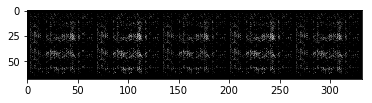

In [24]:
clabel = np.array([4,5,4,4,0])
z = gen_noise(5, clabel)
images = G(z)
# save_image(images, 'xx.png')
plt.imshow(Image.fromarray(make_grid(images).mul(255).clamp(0, 255).byte().permute(1, 2, 0).cpu().numpy()))
plt.show()